## Fraudulent Activities - PART II 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [3]:
df1 = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/Fraud_Data.csv")
ip_country = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/IpAddress_to_Country.csv")

In [4]:
#apply same preprocessing as first part
def transform_ip(arg):
    try:
        return ip_country.country[(ip_country.lower_bound_ip_address < arg) & 
                                  (ip_country.upper_bound_ip_address > arg)].iloc[0]
    except IndexError:
        return "Unknown country"  
      
df1["country_name"] = df1.ip_address.apply(transform_ip)

In [5]:
df1.shape

(151112, 12)

In [6]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [7]:
df1 = df1.iloc[:, 1:]
df1.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [8]:
df1.signup_time = pd.to_datetime(df1.signup_time, format="%Y-%m-%d %H:%M:%S")
df1.purchase_time = pd.to_datetime(df1.purchase_time, format="%Y-%m-%d %H:%M:%S")
df1["time_delta"] = (df1.purchase_time - df1.signup_time)/np.timedelta64(1, 's')

In [9]:
df1.columns

Index(['signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source',
       'browser', 'sex', 'age', 'ip_address', 'class', 'country_name',
       'time_delta'],
      dtype='object')

In [10]:
df1 = df1.rename(columns={"class": "y"})
df1.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,y,country_name,time_delta
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085.0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


In [11]:
df1['year'] = pd.DatetimeIndex(df1['purchase_time']).year
df1['month'] = pd.DatetimeIndex(df1['purchase_time']).month

df1.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,y,country_name,time_delta,year,month
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,2015,4
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,2015,6
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,2015,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085.0,2015,5
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,2015,9


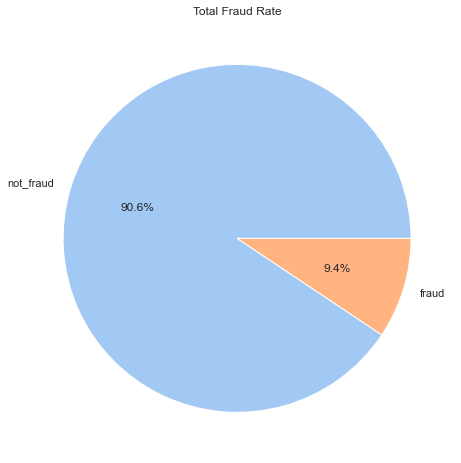

In [12]:
#visualize data
sns.set(style="ticks", palette="pastel")

#fraud rate
fig = plt.figure(figsize=(15,8))
not_fraud = df1[df1.y == 0].y.value_counts()
fraud = df1[df1.y == 1].y.value_counts()

labels = ['not_fraud','fraud']

fraud_pie = np.concatenate((not_fraud, fraud), axis=0)

plt.pie(fraud_pie, labels=labels, autopct='%1.1f%%')
plt.title("Total Fraud Rate")
plt.show()

In [14]:
print(df1.shape)
df1.describe(include='all')

(151112, 14)


/Users/katie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/Users/katie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,y,country_name,time_delta,year,month
count,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000,151112,1.511120e+05,151112.0,151112.000000
unique,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN,182,NaN,NaN,NaN
top,2015-08-12 16:44:20,2015-07-17 23:22:55,NaN,KIPFSCNUGOLDP,SEO,Chrome,M,NaN,NaN,NaN,United States,NaN,NaN,NaN
freq,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN,58049,NaN,NaN,NaN
first,2015-01-01 00:00:42,2015-01-01 00:00:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-08-18 04:40:29,2015-12-16 02:56:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646,NaN,4.932029e+06,2015.0,6.008629
std,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336,NaN,3.126263e+06,0.0,2.660637
min,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN,1.000000e+00,2015.0,1.000000
25%,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000,NaN,2.186754e+06,2015.0,4.000000


In [15]:
#some more processing
df1 = df1.drop(['signup_time', 'purchase_time', 'device_id'], axis=1)

df1 = df1.drop(['ip_address'], axis=1)

df1 = df1.drop(['year'], axis=1)

df1.head()

,purchase_value,source,browser,sex,age,y,country_name,time_delta,month
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,4
1,16,Ads,Chrome,F,53,0,United States,17944.0,6
2,15,SEO,Opera,M,53,1,United States,1.0,1
3,44,SEO,Safari,M,41,0,Unknown country,492085.0,5
4,39,Ads,Safari,M,45,0,United States,4361461.0,9


In [16]:
df1['country_name'].value_counts()

United States      58049
Unknown country    21966
China              12038
Japan               7306
United Kingdom      4490
                   ...  
San Marino             1
Cape Verde             1
Saint Martin           1
Guadeloupe             1
Dominica               1
Name: country_name, Length: 182, dtype: int64

In [17]:
country_counts = df1['country_name'].value_counts()
print(country_counts[country_counts > 50].index.values)

['United States' 'Unknown country' 'China' 'Japan' 'United Kingdom'
 'Korea Republic of' 'Germany' 'France' 'Canada' 'Brazil' 'Italy'
 'Australia' 'Netherlands' 'Russian Federation' 'India'
 'Taiwan; Republic of China (ROC)' 'Mexico' 'Sweden' 'Spain'
 'South Africa' 'Switzerland' 'Poland' 'Argentina' 'Indonesia' 'Norway'
 'Colombia' 'Turkey' 'Viet Nam' 'Romania' 'Denmark' 'Hong Kong' 'Finland'
 'Austria' 'Ukraine' 'Chile' 'Belgium' 'Iran (ISLAMIC Republic Of)'
 'Egypt' 'Czech Republic' 'Thailand' 'New Zealand' 'Israel' 'Saudi Arabia'
 'Venezuela' 'Ireland' 'European Union' 'Greece' 'Portugal' 'Hungary'
 'Malaysia' 'Singapore' 'Pakistan' 'Philippines' 'Bulgaria' 'Morocco'
 'Algeria' 'Peru' 'Tunisia' 'United Arab Emirates' 'Ecuador' 'Lithuania'
 'Seychelles' 'Kenya' 'Kazakhstan' 'Kuwait' 'Costa Rica' 'Slovenia'
 'Slovakia (SLOVAK Republic)' 'Uruguay' 'Croatia (LOCAL Name: Hrvatska)'
 'Luxembourg' 'Belarus' 'Serbia' 'Nigeria' 'Latvia' 'Panama' 'Bolivia'
 'Dominican Republic']


In [18]:
to_keep = country_counts[country_counts > 50].index.values
df1 = df1.loc[df1['country_name'].isin(to_keep),:]

In [19]:
target_name = 'y'

Y = df1.loc[:,target_name]
X = df1.loc[:,[c for c in df1.columns if c!=target_name]] 

In [20]:
X = X.to_numpy()
Y = Y.to_numpy()

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [22]:
numeric_features = [0, 4, 6, 7]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = [1, 2, 3, 5]
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions

In [ ]:
#USE SVM CLASSIFIER
classifier = SVC()
classifier.fit(X_train, Y_train)

In [ ]:
Y_train_pred = classifier.predict(X_train)

Y_test_pred = classifier.predict(X_test)

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

In [ ]:
print('--- Train set ---')
print('Precision : ', precision_score(Y_train, Y_train_pred))
print('Recall : ', recall_score(Y_train, Y_train_pred))
print()
print(confusion_matrix(Y_train, Y_train_pred))
print()
print('--- Test set ---')
print('Precision : ', precision_score(Y_test, Y_test_pred))
print('Recall : ', recall_score(Y_test, Y_test_pred))
print()
print(confusion_matrix(Y_test, Y_test_pred))
print()